# "Gliding" Greedy Policy

Original Simple Greedy policy has one acceptance value for the entire game, it might be worth inspecting if a _gliding_ or changning value througthout the game changes the outcome. 

In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt 

from skyjo.environment import PlayersBoard, Deck, DiscardPile, EXPECTED_VALUE
from skyjo.policies.random_policy import RandomPolicy
from skyjo.policies.greedy_policy import GreedyPolicy
from skyjo.policies.gliding_greedy_policy import GlidingGreedyPolicy, GlidingType

In [7]:
def two_player_game(policy1, policy2, exp1=EXPECTED_VALUE, exp2=EXPECTED_VALUE) -> float:
    deck = Deck()
    discard_pile = DiscardPile()
    
    discard_pile.discard(deck.draw())
    board1 = PlayersBoard([deck.draw() for _ in range(12)])
    if policy1 == GlidingGreedyPolicy:
        player1 = policy1(board1, deck, discard_pile, acceptance_value=exp1, gliding=GlidingType.LINEAR)
    else:
        player1 = policy1(board1, deck, discard_pile, acceptance_value=exp1)

    board2 = PlayersBoard([deck.draw() for _ in range(12)])
    player2 = policy2(board2, deck, discard_pile, acceptance_value=exp2)

    round = 0
    finished = False
    winner = 0
    while True:
        card1, position1 = player1.turn(board2)
        if finished and winner == 1:
            break
        elif board1.is_finished():
            finished = True
            winner = 0
        
        card2, position2 = player2.turn()
        if finished and winner == 0:
            break
        elif board2.is_finished():
            finished = True
            winner = 1
        
        round += 1

    return board1.value(), board2.value()

In [8]:
def policy_performance_plot(ax, policy1, policy2):
    n = 10000
    deck = Deck()
    discard_pile = DiscardPile()
    
    discard_pile.discard(deck.draw())
    board1 = PlayersBoard([deck.draw() for _ in range(12)])
    player1 = policy1(board1, deck, discard_pile)

    board2 = PlayersBoard([deck.draw() for _ in range(12)])
    player2 = policy2(board2, deck, discard_pile)
    
    g = [two_player_game(policy1, policy2, 3.1, 3.1) for _ in range(n)]
    avg_x = round(np.average([x for x, _ in g]), 2)
    avg_y = round(np.average([y for _, y in g]), 2)
    
    ax.set_title(f"{str(player1).split('(')[0]} vs {str(player2).split('(')[0]}")
    ax.set_xlim([-10, 121])
    ax.set_ylim([-10, 121])
    ax.scatter([x for x, _ in g], [y for _, y in g], alpha=0.05)
    ax.scatter(avg_x, avg_y, c="red")
    ax.plot([-10, 120], [-10, 120], "--")
    ax.text(avg_x - 10, avg_y - 10, f"Average score\n {avg_x} x {avg_y}") 
    
    ax.set_xlabel(f"{str(player1).split('(')[0]} score")
    ax.set_ylabel(f"{str(player2).split('(')[0]} score")

In [9]:
n = 10 ** 4
games = {
    k: [two_player_game(GlidingGreedyPolicy, GreedyPolicy, k + 0.1) for _ in range(n)] for k in range(-2, 13)
}
games_3 = {
    k: [two_player_game(GreedyPolicy, GreedyPolicy, k + 0.1) for _ in range(n)] for k in range(-2, 13)
}

In [10]:
avgs = {
    k: (round(np.average([x for x, _ in v]), 2), round(np.average([y for _, y in v]), 2)) for k, v in games.items()
}
avgs_3 = {
    k: (round(np.average([x for x, _ in v]), 2), round(np.average([y for _, y in v]), 2)) for k, v in games_3.items()
}

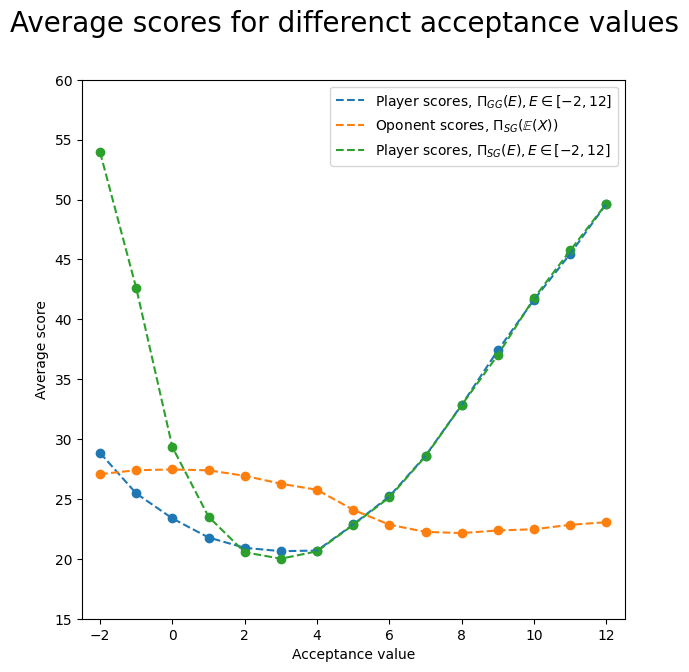

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.plot(avgs.keys(), [v[0] for v in avgs.values()], "--", label=r"Player scores, $\Pi_{GG}(E), E \in [-2,12]$")
ax.scatter(avgs.keys(), [v[0] for v in avgs.values()])

ax.plot(avgs.keys(), [v[1] for v in avgs.values()], "--", label=r"Oponent scores, $\Pi_{SG}(\mathbb{E}(X))$")
ax.scatter(avgs.keys(), [v[1] for v in avgs.values()])

ax.plot(avgs_3.keys(), [v[0] for v in avgs_3.values()], "--", label=r"Player scores, $\Pi_{SG}(E),E \in [-2,12]$")
ax.scatter(avgs_3.keys(), [v[0] for v in avgs_3.values()])

ax.set_xlabel("Acceptance value")
ax.set_ylabel("Average score")
ax.set_xlim([-2.5, 12.5])
ax.set_ylim([15, 60])

fig.suptitle("Average scores for differenct acceptance values", fontsize=20)
ax.legend(loc="upper right")
plt.show()

## Observations
From the plot above it is clear that gliding greedy policy $\Pi_{GG}(E)\ E\in [2, 4]$ doesn't perform better that Simple greedy policy, while for edge cases of $E \in [-2, 1]$ it outperfom the original greedy policy.